<a href="https://colab.research.google.com/github/sdam-au/PHI_ETL/blob/master/scripts/1_4_MODELLING_DATES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements & Auth



In [1]:
import requests
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# our own package for reading the data
!pip install sddk
import sddk

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# read and execute our script for modelling dates
script_url = "https://raw.githubusercontent.com/sdam-au/modelling_temporal_uncertainty/master/scripts/modelling_distributions.py"
# execute the script
exec(requests.get(script_url).content)

In [3]:
# login to sciencedata 
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ··········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [6]:
# read the PHI dataset from sciencedata.dk
# (takes some time - the dataset has almost 400MB)
PHI = sddk.read_file("SDAM_data/PHI/PHI_cleaned_dated_2020-06-30.json", "df", conf)
# older version used during development: PHI = sddk.read_file("SDAM_data/PHI/PHI_enriched_raw.json", "df", conf)
# print first 5 rows of the data
PHI.head(5)

,URL,Book,Text,hdr1,hdr2,tildeinfo,note,lines,metadata,data,filename,PHI_ID,hdr1_scrape,hdr2_scrape,clean_text_conservative,clean_text_interpretive_word,clean_text_interpretive_sentence,raw_date,dating_dict,not_before,not_after,or,date_tags,certainty,link
0,https://epigraphy.packhum.org/text/1,IG I³,1,Regions\n\nAttica (IG I-III)Attica,None,Att. — Ath.: Akr. — stoich. 35 — c. 510-500 a....,None,12.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n,ἔδοχσεν το͂ι δέμοι· τ̣[ὸς ἐ Σ]αλαμ̣[ῖνι κλερόχ...,IG-I-3.csv,1,Regions\nAttica (IG I-III)Attica,IG I³\n1,ἔδοχσεν το͂ι δέμοι ταλαμος οἰκε͂ν ἐᾶ Σαλαμῖνι ...,ἔδοχσεν το͂ι δέμοι τὸς ἐ Σαλαμῖνι κλερόχος οἰκ...,ἔδοχσεν το͂ι δέμοι τὸς ἐ Σαλαμῖνι κλερόχος οἰκ...,c. 510-500 a.,"{'or': None, 'not_before': -511, 'not_after': ...",-511.0,-499.0,None,"[range, phase, ca]",None,None
1,https://epigraphy.packhum.org/text/2,IG I³,2,Regions\n\nAttica (IG I-III)Attica,None,Att. — non-stoich. — c. 500 a.,None,14.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n,[․․8-9․․․]ν̣ βολ — — — — — — — — — —\n[․6-7․․]...,IG-I-3.csv,2,Regions\nAttica (IG I-III)Attica,IG I³\n2,ν βολ α ℎεκον σιον γνοσθε͂ι δὲ ν ἀτεχνος μὲ π ...,ν βολ α ℎεκον σιον γνοσθε͂ι δὲ ν ἀτεχνος μὲ π ...,"․․ ․․․ν βολ ․ ․․ α ⋮ ℎεκον σιον, γνοσθε͂ι δὲ ν...",c. 500 a.,"{'or': None, 'not_before': -505, 'not_after': ...",-505.0,-495.0,None,"[exact, phase, ca]",None,None
2,https://epigraphy.packhum.org/text/3,IG I³,3,Regions\n\nAttica (IG I-III)Attica,None,Att. — stoich. 21 — 490-480 a.,None,13.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n,[․]αρ[․․․․]ι ℎερακλειο[․․5․․]\n[․]αρ̣ο#⁷[․] τι...,IG-I-3.csv,3,Regions\nAttica (IG I-III)Attica,IG I³\n3,αρι ℎερακλειο αρο τιθέναι τὸς ἀέτας τριάκοντα ...,αρι ℎερακλειο αρο τιθέναι τὸς ἀθλοθέτας τριάκο...,αρι ℎερακλειο․․․․ αρο τιθέναι τὸς ἀθλοθέτας τρ...,490-480 a.,"{'or': None, 'not_before': -490, 'not_after': ...",-490.0,-480.0,None,[range],None,None
3,https://epigraphy.packhum.org/text/4,IG I³,4,Regions\n\nAttica (IG I-III)Attica,None,Att. — stoich. 38 — 485/4 a.,None,58.0,\nface A.1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n\...,[․․․․․․․․․․․․․․․․․․38․․․․․․․․․․․․․․․․․․]\n[․․․...,IG-I-3.csv,4,Regions\nAttica (IG I-III)Attica,IG I³\n4,δέ τις αν ἒ φρορὰν μ ντέκοντα δχμὰς τ ας ℎες π...,ἐὰν δέ τις αν ἒ φρορὰν μὲ πεντέκοντα δραχμὰς τ...,․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․ ․․․․․․․․․...,485/4 a.,"{'or': None, 'not_before': -485, 'not_after': ...",-485.0,-484.0,None,[range],None,None
4,https://epigraphy.packhum.org/text/5,IG I³,5,Regions\n\nAttica (IG I-III)Attica,None,Att. — c. 500 a.\n\nSee also:\nI.Eleusis 13,None,6.0,\n1\n\n\n\n \n5\n\n,[ἔδοχσε]ν [⋮ τε͂ι βολε͂ι] ⋮ καὶ [τ]ο͂ι δέμοι ⋮...,IG-I-3.csv,5,Regions\nAttica (IG I-III)Attica,IG I³\n5,ν καὶ ο͂ι δέμοι ℎότε Παραιβάτες λεια θν τὸς ℎι...,ἔδοχσεν τε͂ι βολε͂ι καὶ το͂ι δέμοι ℎότε Παραιβ...,ἔδοχσεν ⋮ τε͂ι βολε͂ι ⋮ καὶ το͂ι δέμοι ⋮ ℎότε ...,c. 500 a.,"{'or': None, 'not_before': -505, 'not_after': ...",-505.0,-495.0,None,"[exact, phase, ca]",None,None


In [121]:
### how many of the inscriptions have at least one date
len(PHI[(PHI["not_before"].notnull()) | (PHI["not_after"].notnull())])

130533

# Generate random dates for the whole dataset

In [7]:
%%time
# generate a list of 1000 random dates for each inscription in the dataset
# takes approx. 90 seconds in Google colab
PHI["random_dates"] = PHI.apply(lambda row: model_date(row["not_before"], row["not_after"], size=1000,), axis=1)

CPU times: user 1min 34s, sys: 5.74 s, total: 1min 40s
Wall time: 1min 40s


In [124]:
PHI.head(20)

,URL,Book,Text,hdr1,hdr2,tildeinfo,note,lines,metadata,data,filename,PHI_ID,hdr1_scrape,hdr2_scrape,clean_text_conservative,clean_text_interpretive_word,clean_text_interpretive_sentence,raw_date,dating_dict,not_before,not_after,or,date_tags,certainty,link,random_dates
0,https://epigraphy.packhum.org/text/1,IG I³,1,Regions\n\nAttica (IG I-III)Attica,None,Att. — Ath.: Akr. — stoich. 35 — c. 510-500 a....,None,12.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n,ἔδοχσεν το͂ι δέμοι· τ̣[ὸς ἐ Σ]αλαμ̣[ῖνι κλερόχ...,IG-I-3.csv,1,Regions\nAttica (IG I-III)Attica,IG I³\n1,ἔδοχσεν το͂ι δέμοι ταλαμος οἰκε͂ν ἐᾶ Σαλαμῖνι ...,ἔδοχσεν το͂ι δέμοι τὸς ἐ Σαλαμῖνι κλερόχος οἰκ...,ἔδοχσεν το͂ι δέμοι τὸς ἐ Σαλαμῖνι κλερόχος οἰκ...,c. 510-500 a.,"{'or': None, 'not_before': -511, 'not_after': ...",-511.0,-499.0,None,"[range, phase, ca]",None,None,"[-505, -505, -504, -500, -509, -502, -502, -50..."
1,https://epigraphy.packhum.org/text/2,IG I³,2,Regions\n\nAttica (IG I-III)Attica,None,Att. — non-stoich. — c. 500 a.,None,14.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n,[․․8-9․․․]ν̣ βολ — — — — — — — — — —\n[․6-7․․]...,IG-I-3.csv,2,Regions\nAttica (IG I-III)Attica,IG I³\n2,ν βολ α ℎεκον σιον γνοσθε͂ι δὲ ν ἀτεχνος μὲ π ...,ν βολ α ℎεκον σιον γνοσθε͂ι δὲ ν ἀτεχνος μὲ π ...,"․․ ․․․ν βολ ․ ․․ α ⋮ ℎεκον σιον, γνοσθε͂ι δὲ ν...",c. 500 a.,"{'or': None, 'not_before': -505, 'not_after': ...",-505.0,-495.0,None,"[exact, phase, ca]",None,None,"[-499, -503, -498, -497, -497, -503, -502, -50..."
2,https://epigraphy.packhum.org/text/3,IG I³,3,Regions\n\nAttica (IG I-III)Attica,None,Att. — stoich. 21 — 490-480 a.,None,13.0,\n1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n,[․]αρ[․․․․]ι ℎερακλειο[․․5․․]\n[․]αρ̣ο#⁷[․] τι...,IG-I-3.csv,3,Regions\nAttica (IG I-III)Attica,IG I³\n3,αρι ℎερακλειο αρο τιθέναι τὸς ἀέτας τριάκοντα ...,αρι ℎερακλειο αρο τιθέναι τὸς ἀθλοθέτας τριάκο...,αρι ℎερακλειο․․․․ αρο τιθέναι τὸς ἀθλοθέτας τρ...,490-480 a.,"{'or': None, 'not_before': -490, 'not_after': ...",-490.0,-480.0,None,[range],None,None,"[-487, -482, -487, -482, -486, -484, -481, -48..."
3,https://epigraphy.packhum.org/text/4,IG I³,4,Regions\n\nAttica (IG I-III)Attica,None,Att. — stoich. 38 — 485/4 a.,None,58.0,\nface A.1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n\...,[․․․․․․․․․․․․․․․․․․38․․․․․․․․․․․․․․․․․․]\n[․․․...,IG-I-3.csv,4,Regions\nAttica (IG I-III)Attica,IG I³\n4,δέ τις αν ἒ φρορὰν μ ντέκοντα δχμὰς τ ας ℎες π...,ἐὰν δέ τις αν ἒ φρορὰν μὲ πεντέκοντα δραχμὰς τ...,․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․․ ․․․․․․․․․...,485/4 a.,"{'or': None, 'not_before': -485, 'not_after': ...",-485.0,-484.0,None,[range],None,None,"[-484, -484, -485, -485, -485, -485, -484, -48..."
4,https://epigraphy.packhum.org/text/5,IG I³,5,Regions\n\nAttica (IG I-III)Attica,None,Att. — c. 500 a.\n\nSee also:\nI.Eleusis 13,None,6.0,\n1\n\n\n\n \n5\n\n,[ἔδοχσε]ν [⋮ τε͂ι βολε͂ι] ⋮ καὶ [τ]ο͂ι δέμοι ⋮...,IG-I-3.csv,5,Regions\nAttica (IG I-III)Attica,IG I³\n5,ν καὶ ο͂ι δέμοι ℎότε Παραιβάτες λεια θν τὸς ℎι...,ἔδοχσεν τε͂ι βολε͂ι καὶ το͂ι δέμοι ℎότε Παραιβ...,ἔδοχσεν ⋮ τε͂ι βολε͂ι ⋮ καὶ το͂ι δέμοι ⋮ ℎότε ...,c. 500 a.,"{'or': None, 'not_before': -505, 'not_after': ...",-505.0,-495.0,None,"[exact, phase, ca]",None,None,"[-496, -500, -504, -500, -498, -499, -499, -50..."
5,https://epigraphy.packhum.org/text/6,IG I³,6,Regions\n\nAttica (IG I-III)Attica,None,Att. — stoich. 23/11 — ante 460 a.\n\nSee also...,None,168.0,\nface A.BM 309.1\n\n\n\n\n5\n\n\n\n\n\n10\n\n...,— — — — — — — — — — — — —\n[․․․․․․15․․․․․․․] δ...,IG-I-3.csv,6,Regions\nAttica (IG I-III)Attica,IG I³\n6,δραχμε͂ιστες τὸς ιο μενος δεμο το͂ν πόλεο οκε͂...,δραχμε͂ισι τες τὸς ιο μενος δεμο το͂ν πόλεον δ...,․․․․․․․․․․․․․ δραχμε͂ισι ․․․․․․․․․․․․τες τὸς ι...,ante 460 a.,"{'or': None, 'not_before': None, 'not_after': ...",NaN,-461.0,None,[ante],None,None,"[-482, -488, -465, -463, -499, -510, -476, -47..."
6,https://epigraphy.packhum.org/text/7,IG I³,7,Regions\n\nAttica (IG I-III)Attica,None,Att. — stoich. 40 — 460-450,None,29.0,\nfrg. a.1\n\n\n\n\n5\n\n\n\n\n\n10\n\n\n\n\n1...,[ἔδοχσεν τε͂]ι βο[λ]ε͂[ι καὶ 

In [8]:
# how many are dated / generated random numbers
len(PHI[PHI["random_dates"].notna()]) / len(PHI)

0.6023617686961819

In [10]:
len(PHI[PHI["hdr1"].str.contains("Attica")])

32652

In [20]:
PHI_asia_minor = PHI[PHI["hdr1"].str.contains("Asia Minor")]

# Playing with random dates

In [188]:
%%time
PHI_complete_simulations = timeblocks_from_randoms(PHI, "random_dates", [-800, 400, 50])

CPU times: user 2min 31s, sys: 3 s, total: 2min 34s
Wall time: 2min 34s


In [ ]:
PHI_complete_simulations[0]

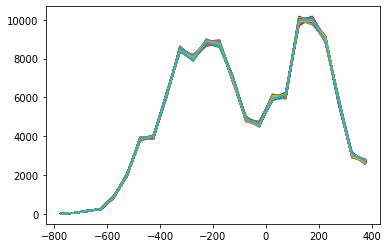

In [194]:
plot_timeblocks_data(PHI_complete_simulations)

In [12]:
# creating a subdataframe
PHI_athens = PHI[PHI["tildeinfo"].str.contains("Athen", na=False)]
PHI_athens

,URL,Book,Text,hdr1,hdr2,tildeinfo,note,lines,metadata,data,filename,PHI_ID,hdr1_scrape,hdr2_scrape,clean_text_conservative,clean_text_interpretive_word,clean_text_interpretive_sentence,raw_date,dating_dict,not_before,not_after,or,date_tags,certainty,link,random_dates
79,https://epigraphy.packhum.org/text/80,IG I³,"78,b",Regions\n\nAttica (IG I-III)Attica,None,Att. — Athens — stoich. 50 — c. 422 a.?\n\nSee...,None,9.0,\n14\n\n15\n\n\n\n\n\n20\n\n\n,"[ἐγλο]-\n[γέας ℎελέσθαι τ]ο͂ καρπο͂, [καθότι ἂ...",IG-I-3.csv,80,Regions\nAttica (IG I-III)Attica,"IG I³\n78,b",ο͂ καρπο͂ αι ἐπειδὰντας παραδισῖνάδε ἐὰν δὲ με...,ἐγλογέας ℎελέσθαι το͂ καρπο͂ καθότι ἂν δοκε͂ι ...,"ἐγλογέας ℎελέσθαι το͂ καρπο͂, καθότι ἂν δοκε͂ι...",c. 422 a.?,"{'or': None, 'certainty': '?', 'not_before': N...",NaN,NaN,None,"[unknown, phase, ca]",?,None,None
159,https://epigraphy.packhum.org/text/160,IG I³,157/213,Regions\n\nAttica (IG I-III)Attica,None,Att. — Athens: Akropolis — stoich. 28 — 440-41...,None,35.0,\na.1\n\n\n\n\n5\n\n\nb.6\n\n\n\n\n10\n\n\n\n\...,[— —․․]οπε— —\n— —θεσεπ— —\n— —εζοσι— —\n— —υπ...,IG-I-3.csv,160,Regions\nAttica (IG I-III)Attica,IG I³\n157/213,οπε θεσεπ εζοσι υποτο να lacuna συμμ ναίον ℎ μ...,οπε θεσεπ εζοσι υποτο να lacuna χσυμμαχ Ἀθεναί...,․․οπε θεσεπ εζοσι υποτο ․․․να lacuna ․․․․ χσυμ...,440-410 a.,"{'or': None, 'not_before': -440, 'not_after': ...",-440.0,-410.0,None,[range],None,None,"[-427, -433, -426, -420, -424, -427, -421, -42..."
416,https://epigraphy.packhum.org/text/417,IG I³,403,Regions\n\nAttica (IG I-III)Attica,None,Att. — Athens — stoich. — c. 416/5 a.,None,85.0,\nface A front.frg. a\n\n1\n\n\n\n\n5\n\n\n\n\...,— — — — — — — — — — — — — — — — — — — — — — — ...,IG-I-3.csv,417,Regions\nAttica (IG I-III)Attica,IG I³\n403,σχ ινα χρυσ σο͂ ἀπὸ μὸν τ Ι στλι πα χρυ συλοι ...,σχ ινα χρυσ χρυσο͂ ἀπὸ το͂ σταθμὸν τ Ι στλιγγὶ...,․․․․․․․σχ ․․․․․․․ινα ․․․․․․χρυσ ․․ χρυσο͂ ἀπὸ ...,c. 416/5 a.,"{'or': None, 'not_before': -416, 'not_after': ...",-416.0,-415.0,None,"[range, phase, ca]",None,None,"[-415, -415, -415, -415, -415, -416, -416, -41..."
417,https://epigraphy.packhum.org/text/418,IG I³,404,Regions\n\nAttica (IG I-III)Attica,None,Att. — Athens — stoich. — c. 416/5 a.,None,43.0,\nfrg. a.1\n\n\n\n\n5\n\n\n\n\n8a\n\nfrg. b.8b...,— — —\n[— — ․]𐅃․ — —\n— — ιν ⋮Ι — — —\n— — φαν...,IG-I-3.csv,418,Regions\nAttica (IG I-III)Attica,IG I³\n404,𐅃 ιν Ι φαν ος Ι σαρ ος χ ισ Ι Δ οα Ι ΟΥ νοι ελ...,𐅃 ιν Ι φαν ος Ι σαρ ος χ ισ Ι Δ οα Ι ΟΥ νοι ελ...,․𐅃․ ιν ⋮Ι φαν ος ⋮Ι σαρ ος χ ․ισ ․Ι ․ ⋮Δ οα . ...,c. 416/5 a.,"{'or': None, 'not_before': -416, 'not_after': ...",-416.0,-415.0,None,"[range, phase, ca]",None,None,"[-416, -416, -416, -415, -416, -415, -416, -41..."
516,https://epigraphy.packhum.org/text/517,IG I³,502,Regions\n\nAttica (IG I-III)Attica,None,Att. — Athens: Agora — 477/6 a. — Hsp. 5.1936....,None,2.0,\n1\n\n,[ἐ͂ μέγ’ Ἀθεναίοισι φόος γένεθ’ ℎενίκ’ Ἀριστο...,IG-I-3.csv,517,Regions\nAttica (IG I-III)Attica,IG I³\n502,ℎαρμόδιο τρίδα γε͂ν ἐθέτεν,ἐ͂ μέγ’ Ἀθεναίοισι φόος γένεθ’ ℎενίκ’ Ἀριστογ...,ἐ͂ μέγ’ Ἀθεναίοισι φόος γένεθ’ ℎενίκ’ Ἀριστογ...,477/6 a.,"{'or': None, 'not_before': -477, 'not_after': ...",-477.0,-476.0,None,[range],None,None,"[-476, -477, -476, -476, -477, -476, -477, -47..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212383,/text/348047?location=1365&patt=&bookid=877&of...,"IG II³,1",1134,Regions\nAttica (IG I-III)\nAttica,"IG II³,1\n1134",Attica — Athens — Akropolis? — undated — IG II...,Honorific decree. Fragment of white marble; n...,7.0,\n\n\n\n\n5\n,[— — — — — — — — — — — — — — —]\n[— — c.11 — —...,IG-II-3-1.csv,348047,None,None,ΛΝΙΗΣ καὶ τοὺς ἐκγόνους αὐτοῦ ΙΣ ἀναγράψαι τόδ...,c ΛΝΙΗΣ καὶ τοὺς ἐκγόνους αὐτοῦ ΙΣ ἀναγράψαι τ...,c. ΛΝΙΗΣ καὶ τοὺς ἐκγόνους αὐτοῦ ΙΣ ἀναγράψαι ...,IG II² 873,"{'or': None, 'not_before': None, 'not_after': ...",NaN,NaN,None,[unknown],None,None,None
213379,/text/349048?location=1223&patt=&bookid=878&of...,"TAM V,3",1456a,Regions\nAsia Mi

In [15]:
athens_sim = timeblocks_from_randoms(PHI_athens, "random_dates", [-800, 400, 100])

In [16]:
athens_sim[0]

[((-800, -700), 10),
 ((-700, -600), 20),
 ((-600, -500), 474),
 ((-500, -400), 1661),
 ((-400, -300), 2309),
 ((-300, -200), 1852),
 ((-200, -100), 955),
 ((-100, 0), 524),
 ((0, 100), 427),
 ((100, 200), 637),
 ((200, 300), 347),
 ((300, 400), 185)]

11230


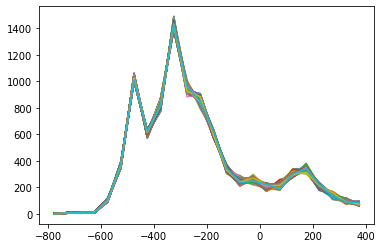

In [18]:
# creating a subdataframe
PHI_athens = PHI[PHI["tildeinfo"].str.contains("Athe", na=False)]
print(len(PHI_athens))
athens_sim = timeblocks_from_randoms(PHI_athens, "random_dates", [-800, 400, 50])
plot_timeblocks_data(athens_sim)

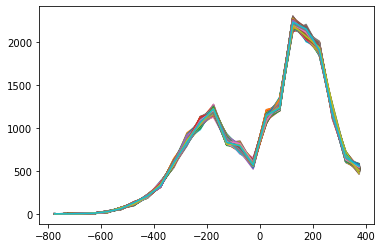

In [21]:
PHI_asia_minor = PHI[PHI["hdr1"].str.contains("Asia Minor")]
PHI_asia_minor_sim = timeblocks_from_randoms(PHI_asia_minor, "random_dates", [-800, 400, 50])
plot_timeblocks_data(PHI_asia_minor_sim)

In [22]:
# for all major regions in hdr1